In [1]:
from typing import Annotated

from langchain_core.tools import tool

# Tools

In [2]:
import requests
from langchain_community.tools.tavily_search import TavilySearchResults
import os

os.environ['TAVILY_API_KEY'] = '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'

@tool
def query_api(query: str):
    """ This tool queries the MOP API and returns the top 3 results """
    
    BASE_URL = "https://mop.rekt.life/v1/query"
    PARAMS = {"query": query}
    
    try:
        response = requests.get(BASE_URL, params=PARAMS)
        
        if response.status_code == 200:
            response = response.json()
            top_items = sorted(response["data"], key=lambda x: x['distance'])[:3]  # Get top 2 items
            return [item['chunk'] for item in top_items]
        else:
            return {"error": f"Error {response.status_code}: {response.text}"}
    except requests.exceptions.RequestException as e:
        return {"error": f"Request failed: {e}"}
    
    
@tool
def tavily_data(query: str):
    """ This tool queries the Tavily API and returns the top 5 results """
    tool = TavilySearchResults(max_results=5)
    results = tool.invoke(query)
    filtered_results = results #[{"title": item["title"], "content": item["content"]} for item in results]
    return filtered_results


In [3]:
# tavily_data("python")
# query_api("btc")

# Load Model

In [4]:
from langchain_huggingface import ChatHuggingFace

In [ ]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from langchain_huggingface.llms.huggingface_pipeline import HuggingFacePipeline
from langchain_huggingface import ChatHuggingFace
import os, torch
from datasets import load_dataset

torch_dtype = torch.float16
attn_implementation = "eager"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch_dtype,
    bnb_4bit_use_double_quant=True,
    llm_int8_enable_fp32_cpu_offload=True
)

tokenizer = AutoTokenizer.from_pretrained("syedanwar/mop-conversation-bot")

model = AutoModelForCausalLM.from_pretrained(
    "syedanwar/mop-conversation-bot",
    torch_dtype=torch.float16,
    # quantization_config=bnb_config,
    device_map="auto",
    attn_implementation=attn_implementation,
)

model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.float16,
    device_map="auto",
    max_new_tokens=512, 
    do_sample=True, 
    temperature=0.9, 
    top_k=250, 
    top_p=0.95
)

hf = HuggingFacePipeline(pipeline=pipe)

c:\Users\Asus\.conda\envs\persona\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
Device set to use cuda:0


In [6]:
chat_model = ChatHuggingFace(llm=hf)

# Agent Nodes

In [7]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        f"\n{suffix}"
    )

In [8]:
def make_system_prompt_for_replier(suffix: str) -> str:
    return (
        "You are a crypto market expert that gives informative answers to user questions based on the context."
        "You can be wrong but you have to be decisive"
        " Use the context given by the `context_builder` to give an answer."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [9]:
from typing import Literal
import re
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command

llm = chat_model

def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        return END
    return goto

# Manually execute tools and pass data to context_builder
def run_tools(state: MessagesState):
    human_message = next(
        (msg for msg in state["messages"] if isinstance(msg, HumanMessage)), None
    )
    if not human_message:
        raise ValueError("No human message found in state")
    
    tool_input = human_message.content  # Extract input string
    # tavily_result = tavily_data(tool_input)
    query_api_result = query_api(tool_input)
    
    # print("Tool tavily_data output:", tavily_result)
    print("Tool query_api output:", query_api_result)
    
    return f"{query_api_result}"

# Research agent and node
def context_node(
    state: MessagesState,
) -> Command[Literal["replier"]]:
    context_data = run_tools(state)  # Manually get tool data
    
    summary_prompt = make_system_prompt(
        f"Generate a detailed summary of the provided context data. Here is the context:\n{context_data}. \n **Strict Instructions**: Write a detailed summary in almost 2 or 3 paragraphs not less."
    )
    
    context_builder = create_react_agent(
        llm,
        tools=[],
        prompt=summary_prompt,
    )
    
    result = context_builder.invoke({"messages": state["messages"]})
    summary = result["messages"][-1].content  # Extract only the summary
    pattern = r'<\|end_header_id\|>(?!.*<\|end_header_id\|>)(.*)'

    match = re.search(pattern, summary, re.DOTALL)
    result = match.group(1).strip()
    
    print("Generated Summary:", result)
    
    return Command(
        update={
            "messages": [HumanMessage(content=summary, name="context_summary")],
        },
        goto="replier",
    )

# ---------------------------------------- Replier AGENT ----------------------------------------
replier = create_react_agent(
    llm,
    tools=[],
    prompt=make_system_prompt_for_replier(
        "Answer the user question based on the provided summary. It should not be completely same as the summary."
    ),
)

def replier_node(state: MessagesState) -> Command[Literal["context_builder", END]]:
    result = replier.invoke(state)
    goto = get_next_node(result["messages"][-1], "context_builder")
    
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="replier"
    )
    return Command(
        update={
            "messages": result["messages"],
        },
        goto=goto,
    )

In [10]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("context_builder", context_node)
workflow.add_node("replier", replier_node)

workflow.add_edge(START, "context_builder")
graph = workflow.compile()

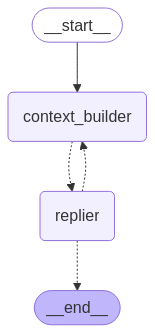

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "If I had to jump into crypto today, what would suggest I go for?",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

C:\Users\Asus\AppData\Local\Temp\ipykernel_27840\2688784895.py:25: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  query_api_result = query_api(tool_input)


Tool query_api output: ['Name: The Next Bitcoin\nSymbol: BUTTCOIN\nTokenAddress: FasH397CeZLNYWkd3wWK9vrmjd1z93n3b59DssRXpump\nDescription: Unlock the power of your farts by collecting butt coins.\r\n\nPriceUsd: 0.001604\nPriceChange1h: 1.286706\nPriceChange24h: -4.225911\nMarketCapUsd: 1602513.443273\nVolume24h: 1786458.000000\nCirculatingSupply: 998905653.599375\nTotalSupply: 998905653.599375\nMaxSupply: 998905653.599375\nSource: solana_tracker\nPlatform: Solana', 'Name: The Next Bitcoin\nSymbol: BUTTCOIN\nTokenAddress: FasH397CeZLNYWkd3wWK9vrmjd1z93n3b59DssRXpump\nDescription: Unlock the power of your farts by collecting butt coins.\r\n\nPriceUsd: 0.001848\nPriceChange1h: 7.140283\nPriceChange24h: 16.638152\nMarketCapUsd: 1845609.522512\nVolume24h: 1831351.000000\nCirculatingSupply: 998905653.599375\nTotalSupply: 998905653.599375\nMaxSupply: 998905653.599375\nSource: solana_tracker\nPlatform: Solana', 'Name: The Next Bitcoin\nSymbol: BUTTCOIN\nTokenAddress: FasH397CeZLNYWkd3wWK9vrmj